<a href="https://colab.research.google.com/github/thwlruss10/VDA_pipeline/blob/main/VILT_inference_17APR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers datasets nltk scikit-learn

In [ ]:
from transformers import ViltForQuestionAnswering, ViltProcessor

model = ViltForQuestionAnswering.from_pretrained("/content/drive/MyDrive/FinalProject/vilt_checkpoint")
processor = ViltProcessor.from_pretrained("/content/drive/MyDrive/FinalProject/vilt_checkpoint")



In [ ]:
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split

# Define base directory pointing to your Drive location
base_dir = "/content/drive/MyDrive/FinalProject/dataset"
os.makedirs(base_dir, exist_ok=True)

# Define regex to extract image ID
image_pattern = re.compile(r"( (in |on |of )?(the |this )?(image\d*) \?)")

# Read the raw Q&A file
# Extracts image ID and question at index[i] together with answer at [i+1]
# and organizes it into a pandas DataFrame, creates a list of unique answers,
# and then splits the dataset into training and testing sets, saving them as
# CSV.

qa_file = os.path.join(base_dir, "all_qa_pairs.txt")
with open(qa_file, "r", encoding="utf-8") as f: # open in read mode with in utf-8 encoding
    qa_data = [x.strip() for x in f.readlines()] # x.strip() removes white spaces

records = []
for i in range(0, len(qa_data), 2): # iterates in steps of two because quesiton is at index i and answer at i+1
    match = image_pattern.findall(qa_data[i]) # extract image ID from question string
    if match:
        img_id = match[0][3]
        question = qa_data[i].replace(match[0][0], "").strip() # remove image ID and replace question
        answer = qa_data[i + 1].strip() # answer retrieved from next element
        records.append({"question": question, "answer": answer, "image_id": img_id}) #populate dictionary



df = pd.DataFrame(records)


answer_space = []
for ans in df["answer"].to_list():
    if "," in ans:
        answer_space += ans.replace(" ", "").split(",")
    else:
        answer_space.append(ans)

# sort and remove duplicates from answer_space
answer_space = sorted(set(answer_space))

# Write the answer space to file
with open(os.path.join(base_dir, "answer_space.txt"), "w", encoding="utf-8") as f:
    f.writelines("\n".join(answer_space))

# Split dataset into training and evaluation
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Save to CSV
train_df.to_csv(os.path.join(base_dir, "data_train.csv"), index=False)
test_df.to_csv(os.path.join(base_dir, "data_eval.csv"), index=False)


In [ ]:
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import re
import pandas as pd
import os
from transformers import (
    # Preprocessing / Common
    AutoTokenizer, AutoFeatureExtractor,
    # Text & Image Models & transformers (ViTModel, DeiTModel, BEiT)
    AutoModel,
    # Training / Evaluation
    TrainingArguments, Trainer,
    # Misc
    logging
)

# import nltk
# nltk.download('wordnet')

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# SET CACHE FOR HUGGINGFACE TRANSFORMERS + DATASETS
os.environ['HF_HOME'] = os.path.join(".", "cache")
# SET ONLY 1 GPU DEVICE
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

#set_caching_enabled(True)>> this line deleted as 'datasets' no longer supports explicit cahce enabling
#set_caching_enabled(True)
logging.set_verbosity_error()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from nltk.corpus import wordnet as wn

def wup_measure(pred, gt, threshold=0.9):
    pred_synsets = wn.synsets(pred)
    gt_synsets = wn.synsets(gt)

    if not pred_synsets or not gt_synsets:
        return 0.0

    max_score = max((s1.wup_similarity(s2) or 0) for s1 in pred_synsets for s2 in gt_synsets)
    return 1.0 if max_score >= threshold else max_score

In [ ]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset,
})


In [ ]:
from datasets import load_dataset
from IPython.display import display
from PIL import Image
import numpy as np
import os

# Set the correct image directory in Google Drive
image_dir = "/content/drive/MyDrive/FinalProject/dataset/images"

def showExample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]

    if id is None:
        id = np.random.randint(len(data))

    img_path = os.path.join(image_dir, data[id]["image_id"] + ".png")

    if not os.path.exists(img_path):
        print(f"⚠️ Image not found at: {img_path}")
        return


    # Define question and image path
    question = data[id]["question"]
    #  image_path = "/content/drive/MyDrive/FinalProject/dataset/images/image3.png"

    # Load image as RGB PIL object
    image = Image.open(img_path).convert("RGB")

    # Preprocess inputs
    inputs = processor(text=question, images=image, return_tensors="pt")

    # Run model
    with torch.no_grad():
        outputs = model(**inputs)

    # Get predicted answer index and label
    logits = outputs.logits
    predicted_idx = logits.argmax(-1).item()
    predicted_answer = answer_space[predicted_idx]
    wup_score = wup_measure(pred=predicted_answer, gt=data[id]["answer"])

    print(f"✅ Found image at: {os.path.abspath(img_path)}")
    #  image = Image.open(img_path)
    display(image)

    print("Question:\t", question)
    #label = data[id].get("label", "N/A")  # fallback if key is missing
    #print("Answer:\t\t", data[id]["answer"], f"(Label: {label})")
    print("Answer:\t\t", data[id]["answer"])
    print("Predicted answer:", predicted_answer)
    print("WUP Score:", wup_score)

# Show a random training example


✅ Found image at: /content/drive/MyDrive/FinalProject/dataset/images/image1061.png


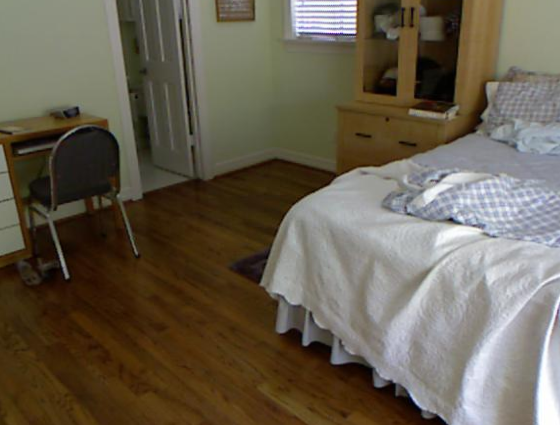

Question:	 what is in front of the table
Answer:		 chair
Predicted answer: table
WUP Score: 0.8421052631578947


In [ ]:
showExample()

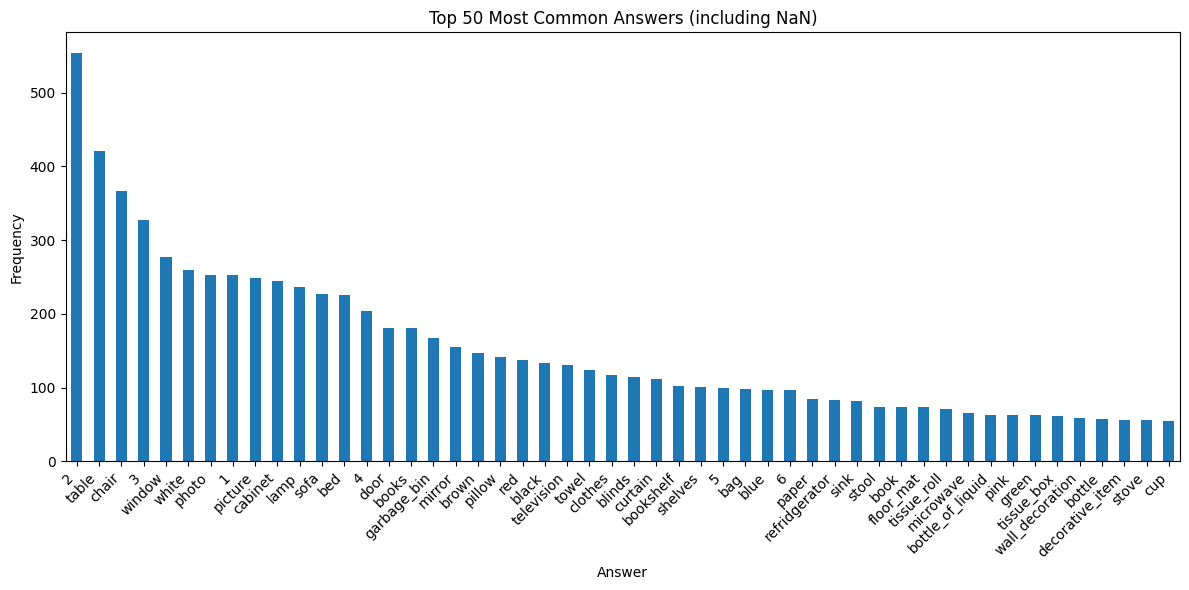

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

base_dir = "/content/drive/MyDrive/FinalProject/dataset"
eval_df = pd.read_csv(os.path.join(base_dir, "data_eval.csv"))


df['answer'] = df['answer'].astype(str).str.strip().str.lower()

# Count frequency of each unique answer, including NaN values
answer_counts = df['answer'].value_counts(dropna=False)

# Plot histogram of top N most common answers (e.g., top 50)
top_n = 50
plt.figure(figsize=(12, 6))
answer_counts[:top_n].plot(kind='bar')
plt.title(f'Top {top_n} Most Common Answers (including NaN)')
plt.xlabel('Answer')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
from PIL import Image
import torch
from transformers import ViltProcessor, ViltForQuestionAnswering

# Load your trained model and processor
# model = ViltForQuestionAnswering.from_pretrained("path_to_your_saved_model")
# processor = ViltProcessor.from_pretrained("path_to_your_saved_model")

# Load answer space from file
answer_space_path = "/content/drive/MyDrive/FinalProject/dataset/answer_space.txt"
with open(answer_space_path, "r", encoding="utf-8") as f:
    answer_space = f.read().splitlines()

# Define question and image path
question = "What is the color of the chair in front of the white wall?"
image_path = "/content/drive/MyDrive/FinalProject/dataset/images/image3.png"

# Load image as RGB PIL object
image = Image.open(image_path).convert("RGB")

# Preprocess inputs
inputs = processor(text=question, images=image, return_tensors="pt")

# Run model
with torch.no_grad():
    outputs = model(**inputs)

# Get predicted answer index and label
logits = outputs.logits
predicted_idx = logits.argmax(-1).item()
predicted_answer = answer_space[predicted_idx]

print("Predicted answer:", predicted_answer)


Predicted answer: white
